# Deep Learning Trading Bot


In [1]:
# Essential
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import pandas as pd

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

# Neural Networks
from models import RNN, LSTM

# Progress bar
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Financial
import websocket
import config
from binance.client import Client



ModuleNotFoundError: No module named 'pytorch_lightning'

## Dataset and Dataloader

In [4]:
# Take data fromm a fictious market

client = Client(config.API_KEY, config.API_SECRET, testnet= True)

klines = np.array(client.get_historical_klines("BNBUSDT", Client.KLINE_INTERVAL_1HOUR, "1 Oct, 2021", "20 Oct, 2021"))

def binanceDataFrame(klines):
    df = pd.DataFrame(klines.reshape(-1,12), dtype=float, columns = ('Open Time',
                                                                     'Open',
                                                                     'High',
                                                                     'Low',
                                                                     'Close',
                                                                     'Volume',
                                                                     'Close time',
                                                                     'Quote asset volume',
                                                                     'Number of trades',
                                                                     'Taker buy base asset volume',
                                                                     'Taker buy quote asset volume',
                                                                     'Ignore'))

    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')

    return df

df = binanceDataFrame(klines)

In [5]:
df

,Open Time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2021-10-01 05:00:00,388.90,389.10,388.90,389.10,2.29,1.633068e+12,890.7810,2.0,0.00,0.0000,0.0
1,2021-10-01 06:00:00,389.40,392.39,193.64,392.13,300.40,1.633072e+12,111433.0327,417.0,167.57,64094.8897,0.0
2,2021-10-01 07:00:00,392.13,397.66,196.14,397.01,1656.66,1.633075e+12,646570.2127,1090.0,1602.25,625822.4551,0.0
3,2021-10-01 08:00:00,397.01,404.50,395.31,404.50,1158.74,1.633079e+12,460756.3242,758.0,1105.94,439671.4097,0.0
4,2021-10-01 09:00:00,402.96,402.96,401.30,402.46,444.32,1.633082e+12,178801.7565,312.0,141.74,57021.9095,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
447,2021-10-19 20:00:00,482.90,483.50,482.10,483.30,4.24,1.634677e+12,2046.1880,21.0,0.59,285.0310,0.0
448,2021-10-19 21:00:00,483.40,484.90,483.40,484.90,0.20,1.634681e+12,96.7900,6.0,0.06,29.0070,0.0
449,2021-10-19 22:00:00,486.40,486.40,485.90,485.90,2.16,1.634684e+12,1050.1620,3.0,1.03,500.9920,0.0
450,2021-10-19 23:00:00,485.90,485.90,485.90,485.90,0.00,1.634688e+12,0.0000,0.0,0.00,0.0000,0.0


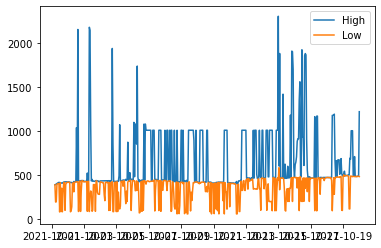

In [6]:
open_time = np.array(df["Open Time"])
high = np.array(df["High"])
low = np.array(df["Low"])

plt.plot(open_time, high, label = "High")
plt.plot(open_time, low, label = "Low")
plt.legend()
plt.show()

# Define the Network

In [7]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
x_dim = 3
h_dim = 3

net = LSTM(x_dim, h_dim)

### Move to device
#net.to(device)

Training device: cuda


In [8]:
# Check if the nets are working properly

x = torch.randn(1,x_dim)
h = torch.randn(1,h_dim)
C = torch.randn(1,h_dim)

out = net(x,h, C)
print(out[0])

tensor([[0.5427, 0.6685, 0.4818]], grad_fn=<SigmoidBackward>)


# Training

In [ ]:
# Define the loss function
loss_function = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

# Define the optimizers
optimizer_1 = optim.Adam(params_to_optimize, lr = lr, weight_decay = 1e-5)
optimizer_2 = optim.SGD(params_to_optimize, lr = lr, momentum = 1.4, weight_decay = 0.1)

### Training loop with progress bar

num_epochs = 50


train_loss_log = []
val_loss_log = []

pbar = tqdm_notebook(range(num_epochs))

for epoch_num in pbar:
    
    # Train an epoch and save losses
    train_epoch_loss = train_epoch(encoder, decoder, device, train_dataloader, loss_function, optimizer_1)
    # Validate an epoch
    val_epoch_loss = val_epoch(encoder, decoder,  device, val_dataloader, loss_function)
    # Compute averages over an epoch
    mean_train_loss = np.mean(train_epoch_loss)
    mean_val_loss = np.mean(val_epoch_loss)
    # Append to plot
    train_loss_log.append(mean_train_loss)
    val_loss_log.append(mean_val_loss)
    pbar.set_description("Train loss: %s" %round(mean_train_loss,3)+","+"Validation loss %s" %round(mean_val_loss,3))
    
    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_data[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch_num + 1))
    plt.show()
    plt.close()
    
    sleep(0.03)
    pbar.update()

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Save and load model

In [ ]:
### Save network parameters
### Save the network state
# Save network parameters
torch.save(encoder.state_dict(), 'encoder_params.pth')
torch.save(decoder.state_dict(), 'decoder_params.pth')

In [ ]:
### Reload the network state
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))